If the plots are displayed, either take a leap of faith and click the `Not Trusted` button on the top right to trust the embedded java-script, or execute the notebook again.

# NMR Data Analysis
The following code replicates the NMR data analysis in Fig. 4, including the full MnCl$_2$ analysis that is not shown in the paper in the interest of brevity.

For this analysis we need the following packages:

In [1]:
using MRIgeneralizedBloch
using DifferentialEquations
using LinearAlgebra
using LsqFit
using Statistics
import Pingouin
using Printf
using Formatting
using Plots
plotlyjs(ticks=:native);

The raw data is stored in a separate [github repository](https://github.com/JakobAsslaender/MRIgeneralizedBloch_NMRData) and the following functions return the URL to the individual files:

In [2]:
MnCl2_data(TRF_scale) = string("https://github.com/JakobAsslaender/MRIgeneralizedBloch_NMRData/blob/main/20210419_1mM_MnCl2/ja_IR_v2%20(", TRF_scale, ")/1/data.2d?raw=true")
BSA_data(TRF_scale)   = string("https://github.com/JakobAsslaender/MRIgeneralizedBloch_NMRData/blob/main/20210416_15%25BSA_2ndBatch/ja_IR_v2%20(", TRF_scale, ")/1/data.2d?raw=true")
nothing #hide

which can be loaded with functions implemented in this file:

In [3]:
include(string(pathof(MRIgeneralizedBloch), "/../../docs/src/load_NMR_data.jl"))
nothing #hide

## MnCl$_2$ Probe
### $T_2^{*,f}$ Estimation
We estimate $T_2^{*,f}$ by fitting a mono-exponential decay curve to the FID of the acquisition with $T_\text{RF} = 22.8$μs and $T_\text{i} = 5$s.

In [4]:
M = load_Data(MnCl2_data(1))
M = M[:,1] # select Ti = 5s
nothing #hide

The data was measured at the following time points in units of seconds:

In [5]:
T_dwell = 100e-6 # s
TE = T_dwell * ((1:length(M)) .+ 7) # s

0.0008:0.0001:1.6378

Note that the signal is an FID, so the phrase *echo* time is a bit misleading.

The function [curve_fit](https://julianlsolvers.github.io/LsqFit.jl/latest/api/#LsqFit.curve_fit) from the [LsqFit.jl](https://julianlsolvers.github.io/LsqFit.jl/latest/) package is only implemented for real-valued models. To accommodate this, we need to split the data into its real and imaginary part:

In [6]:
TEreal = [TE;TE]
Mreal = [real(M);imag(M)]
nothing #hide

Here, we are using a simple mono-exponential model with a complex-valued scaling factor `p[1] + 1im p[2]`, the decay time $T_2^{*,f} =$ `p[3]`, and the Larmor frequency `p[4]`:

In [7]:
FID_model(t, p) = @. [p[1] * exp(- t[1:end ÷ 2] / p[3]) * cos(p[4] * t[1:end ÷ 2]); p[2] * exp(- t[end ÷ 2 + 1:end] / p[3]) * sin(p[4] * t[end ÷ 2 + 1:end])]
nothing #hide

Fitting this model to the NMR data estimates $T_2^{*,f}$:

In [8]:
fit = curve_fit(FID_model, TEreal, Mreal, [1, 1, 0.1, 0])
T2star_MnCl2 = fit.param[3] # s

0.07497933747410088

seconds and its uncertainty (also in units of seconds)

In [9]:
stderror(fit)[3] # s

1.7377694953692984e-5

Visually, the plot and the data show good agreement:

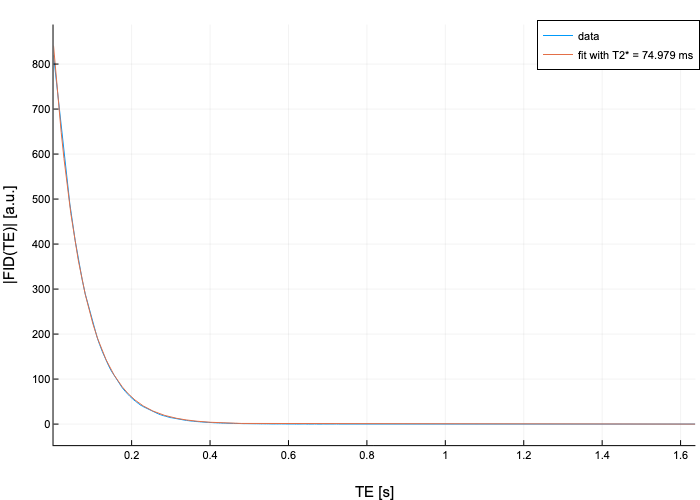

In [10]:
Mfitted = FID_model(TEreal, fit.param)
Mfitted = Mfitted[1:end÷2] + 1im * Mfitted[end÷2+1:end]
p = plot(xlabel="TE [s]", ylabel="|FID(TE)| [a.u.]")
plot!(p, TE, abs.(M), label="data")
plot!(p, TE, abs.(Mfitted), label=@sprintf("fit with T2* = %2.3f ms", 1e3 * T2star_MnCl2))

The relative residual norm of the fit, i.e. $||residual||_2/||M||_2$ is

In [11]:
norm(fit.resid) / norm(M)

0.01350365065641344

Despite its small $\ell_2$-norm, the Shapiro-Wilk test indicates that the residual is not Gaussian or normal distributed at a significance level of `α=0.05`

In [12]:
Pingouin.normality(fit.resid, α=0.05)

[WARN] x contains more than 5000 samples. The test might be incorrect.┌ Warning: p-value may be unreliable for samples larger than 5000 points
└ @ Pingouin ~/.julia/packages/Pingouin/L0EE5/src/_shapiro.jl:185


1×3 DataFrame
 Row │ W         pval          normal
     │ Float64   Float64       Bool
─────┼────────────────────────────────
   1 │ 0.483365  6.38071e-131   false

We note that mono-exponential $T_2^*$ decays assume a Lorentzian distributed magnetic field, which is in general an assumption rather than a well-founded theory.

### Mono-Exponential IR Model
We performed several experiments in which we inverted the thermal equilibrium magnetization with rectangular π-pulses with the following pulse durations (in seconds):

In [13]:
TRFmin = 22.8e-6 # s - shortest TRF possible on the NMR
TRF_scale = [1;2;5:5:40] # scaling factor
TRF = TRF_scale * TRFmin # s

10-element Vector{Float64}:
 2.28e-5
 4.56e-5
 0.00011399999999999999
 0.00022799999999999999
 0.00034199999999999996
 0.00045599999999999997
 0.00057
 0.0006839999999999999
 0.000798
 0.0009119999999999999

and acquired inversion recovery data at exponentially spaced inversion times (in seconds):

In [14]:
Ti = exp.(range(log(3e-3), log(5), length=20)) # s
Ti .+= 12 * TRFmin + (13 * 15.065 - 5) * 1e-6 # s - correction factors

20-element Vector{Float64}:
 0.003464444999999999
 0.0048973889644219615
 0.007014775730568361
 0.010143528025680238
 0.014766722559942762
 0.02159817666227864
 0.03169266107267046
 0.046608755653003126
 0.06864949280054741
 0.10121794370375319
 0.1493426496577329
 0.22045402459049154
 0.32553160469379794
 0.4807992795321372
 0.7102302468802864
 1.049248454199443
 1.550198026187646
 2.2904251533959354
 3.3842202786824003
 5.0004644449999995

We calculate the Rabi frequencies of the RF pulses and a finer grid of $T_\text{i}$ to plot the IR model:

In [15]:
ω1 = π ./ TRF # rad/s
TIplot = exp.(range(log(Ti[1]), log(Ti[end]), length=500)) # s
nothing #hide

After loading and normalizing the data

In [16]:
M = zeros(Float64, length(Ti), length(TRF_scale))
for i = 1:length(TRF_scale)
    M[:,i] = load_spectral_integral(MnCl2_data(TRF_scale[i]))
end
M ./= maximum(M)
nothing #hide

we analyze each inversion recovery curve that corresponds to a different $T_\text{RF}$ separately. This allows us to fit a simple mono-exponential model

In [17]:
standard_IR_model(t, p) = @. p[1] - p[3] * exp(- t * p[2])
nothing #hide

where `p[1]` is the thermal equilibrium magnetization, `p[2]` $= T_1$, and `p[1] - p[3]` is the magnetization right after the inversion pulse or, equivalently, `Minv = p[1] / p[3] - 1` is the inversion efficiency, which is 1 for an ideal π-pulse and smaller otherwise. The parameters are initialized with

In [18]:
p0 = [1.0, 1.0, 2.0]
nothing #hide

and we can loop over $T_\text{RF}$ to perform the fits:

┌ Warning: Assignment to `fit` in soft scope is ambiguous because a global variable by the same name exists: `fit` will be treated as a new local. Disambiguate by using `local fit` to suppress this warning or `global fit` to assign to the existing global variable.
└ @ string:7


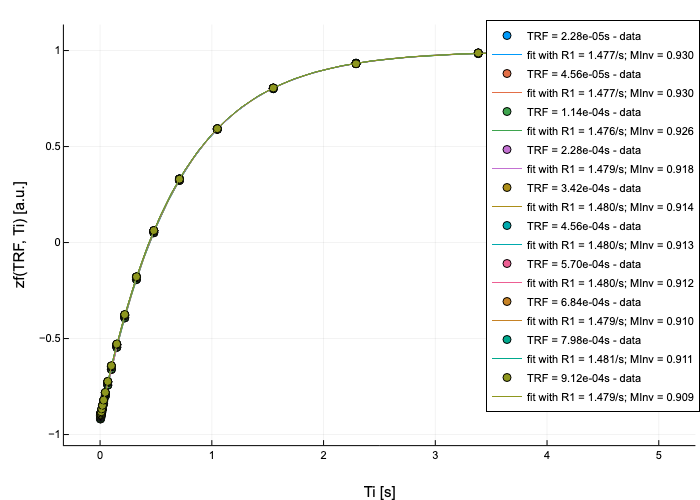

In [19]:
R1 = similar(M[1,:])
residual = similar(R1)
p = plot(xlabel="Ti [s]", ylabel="zf(TRF, Ti) [a.u.]")
for i = 1:length(TRF_scale)
    Mi = @view M[:,i]

    fit = curve_fit(standard_IR_model, Ti, Mi, p0)

    R1[i] = fit.param[2]
    Minv = fit.param[3] / fit.param[1] - 1

    residual[i] = norm(fit.resid) / norm(Mi)

    scatter!(p, Ti, Mi, label=@sprintf("TRF = %1.2es - data", TRF[i]), color=i)
    plot!(p, TIplot, standard_IR_model(TIplot, fit.param), label=@sprintf("fit with R1 = %.3f/s; MInv = %.3f", R1[i], Minv), color=i)
end
gui() #hide

Here, the data measured with different $T_\text{RF}$ are indicated by markers in different colors, and the corresponding fits are the line plots in the same color. The fitted parameters are denoted in the legend and the mean value of all R1 estimates is

In [20]:
mean(R1) # 1/s

1.4787413101704776

1/s and its standard deviation in units of 1/s is

In [21]:
std(R1) # 1/s

0.0015907797512636085

The relative residual norm of the fits is on average

In [22]:
mean(residual)

0.001376794169029043

Further, we cannot reject the null hypothesis that the estimated R1 values are Gaussian distributed:

In [23]:
Pingouin.normality(R1, α=0.05)

1×3 DataFrame
 Row │ W         pval      normal
     │ Float64   Float64   Bool
─────┼────────────────────────────
   1 │ 0.940419  0.557689    true

### Global IR fit
As an alternative to individual fits to the inversion recovery curves with different $T_\text{RF}$, we can also perform a global fit that accounts for the $T_2^{*,f}$ decay during the inversion pulse. The model first simulates the $T_2^{*,f}$ decay during the inversion pulse, followed by $T_1$ recovery:

In [24]:
function Bloch_IR_model(p, TRF, Ti, T2)
    (m0, m0_inv, R1) = p
    R2 = 1 / T2

    M = zeros(Float64, length(Ti), length(TRF))
    for i = 1:length(TRF)
        # simulate inversion pulse
        ω1 = π / TRF[i]
        H = [-R2 -ω1  0;
              ω1 -R1 R1;
               0   0  0]

        m_inv = m0_inv * (exp(H * TRF[i]) * [0,1,1])[2]

        # simulate T1 recovery
        H = [-R1 R1 * m0;
               0       0]

        for j = 1:length(Ti)
            M[j,i] = m0 * (exp(H .* (Ti[j] - TRF[i] / 2)) * [m_inv,1])[1]
        end
    end
    return vec(M)
end
nothing #hide

We use the previously estimated $T_2^{*,f}$ value for the fit:

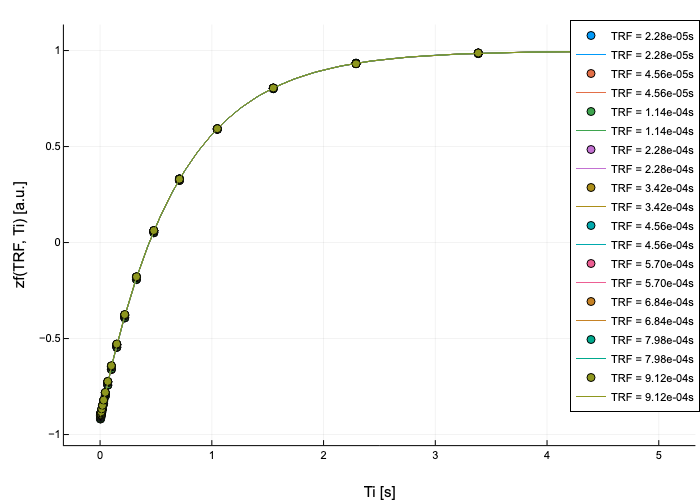

In [25]:
fit = curve_fit((x, p) -> Bloch_IR_model(p, TRF, Ti, T2star_MnCl2), 1:length(M), vec(M), [ 1, .8, 1])

p = plot(xlabel="Ti [s]", ylabel="zf(TRF, Ti) [a.u.]")
for i=1:length(TRF)
    scatter!(p, Ti, M[:,i], label=@sprintf("TRF = %1.2es", TRF[i]), color=i)
    plot!(p, TIplot, Bloch_IR_model(fit.param, TRF[i], TIplot, T2star_MnCl2), label=@sprintf("TRF = %1.2es", TRF[i]), color=i)
end
gui() #hide

With this global fit, we get a very similar relaxation rate in units of 1/s

In [26]:
R1_MnCl2 = fit.param[3] # 1/s

1.478732620464534

with an uncertainty (also in units of 1/s) of

In [27]:
stderror(fit)[3] # 1/s

0.0025253449960101716

Note that the relative residual norm is somewhat increased compared to individual fits to each inversion recovery curve:

In [28]:
norm(fit.resid) / norm(M)

0.0069842779739412225

## Bovine Serum Albumin Probe
### $T_2^{*,f}$ Estimation
We repeat the $T_2^{*,f}$ estimation for the bovine serum albumin (BSA) probe by fitting a mono-exponential decay curve to the FID of the acquisition with $T_\text{RF} = 22.8$μs and $T_\text{i} = 5$s.

In [29]:
M = load_Data(BSA_data(1));
M = M[:,1] # select Ti = 5s
Mreal = [real(M);imag(M)]

fit = curve_fit(FID_model, TEreal, Mreal, [1.0, 1.0, .1, 0.0])
nothing #hide

The estimated $T_2^{*,f}$ of the BSA probe is

In [30]:
T2star_BSA = fit.param[3] # s

0.05240554904974235

seconds with an uncertainty of

In [31]:
stderror(fit)[3] # s

7.029510435085191e-6

seconds.

Visually, the plot and the data align well for the BSA probe, too:

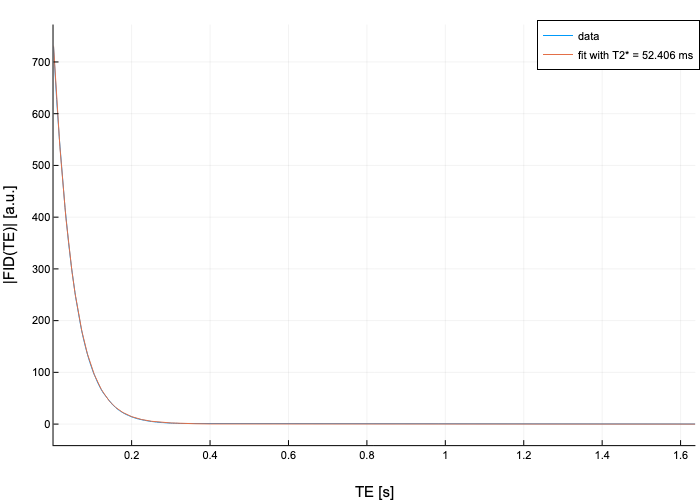

In [32]:
Mfitted = FID_model(TEreal, fit.param)
Mfitted = Mfitted[1:end÷2] + 1im * Mfitted[end÷2+1:end]
p = plot(xlabel="TE [s]", ylabel="|FID(TE)| [a.u.]")
plot!(p, TE, abs.(M), label="data")
plot!(p, TE, abs.(Mfitted), label=@sprintf("fit with T2* = %2.3f ms", 1e3 * T2star_BSA))

The relative residual norm ($||residual||_2/||M||_2$) is

In [33]:
norm(fit.resid) / norm(M)

0.006257402534109855

Despite the small residual, the Shapiro-Wilk test indicates that the residual is not normal distributed for this probe either:

In [34]:
Pingouin.normality(fit.resid, α=0.05)

[WARN] x contains more than 5000 samples. The test might be incorrect.┌ Warning: p-value may be unreliable for samples larger than 5000 points
└ @ Pingouin ~/.julia/packages/Pingouin/L0EE5/src/_shapiro.jl:185


1×3 DataFrame
 Row │ W         pval          normal
     │ Float64   Float64       Bool
─────┼────────────────────────────────
   1 │ 0.534965  7.08004e-128   false

### Mono-Exponential IR Model
We also fit a mono-exponential model to each inversion recovery curve of the BSA data:

┌ Warning: Assignment to `fit` in soft scope is ambiguous because a global variable by the same name exists: `fit` will be treated as a new local. Disambiguate by using `local fit` to suppress this warning or `global fit` to assign to the existing global variable.
└ @ string:13


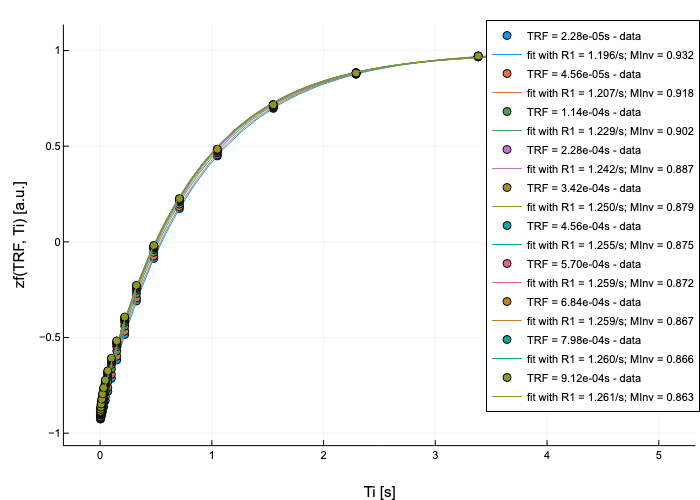

In [35]:
M = zeros(Float64, length(Ti), length(TRF_scale))
for i = 1:length(TRF_scale)
    M[:,i] = load_spectral_integral(BSA_data(TRF_scale[i]))
end
M ./= maximum(M)

R1 = similar(M[1,:])
residual = similar(R1)
p = plot(xlabel="Ti [s]", ylabel="zf(TRF, Ti) [a.u.]")
for i = 1:length(TRF_scale)
    Mi = @view M[:,i]

    fit = curve_fit(standard_IR_model, Ti, Mi, p0)

    R1[i] = fit.param[2]
    Minv = fit.param[3] / fit.param[1] - 1

    residual[i] = norm(fit.resid) / norm(Mi)

    scatter!(p, Ti, Mi, label=@sprintf("TRF = %1.2es - data", TRF[i]), color=i)
    plot!(p, TIplot, standard_IR_model(TIplot, fit.param), label=@sprintf("fit with R1 = %.3f/s; MInv = %.3f", R1[i], Minv), color=i)
end
gui() #hide

Zooming into early phase of the recovery curve reveals the poor fit quality, in particular for long $T_\text{RF}$. This is also reflected by a substantially larger relative residual norm compared to the MnCl$_2$ probe:

In [36]:
mean(residual)

0.019245471196902057

The mean of all R1 fits in units of 1/s is

In [37]:
mean(R1) # 1/s

1.2417851580725343

and its standard deviation is substantially larger compared to the same fit of the MnCl$_2$ probe:

In [38]:
std(R1) # 1/s

0.02362174853649282

In contrast to the MnCl$_2$ probe, we can reject the null hypothesis that the R1 rates, estimated with a mono-exponential model from the BSA probe with different $T_\text{RF}$, are Gaussian distributed:

In [39]:
Pingouin.normality(R1, α=0.05)

1×3 DataFrame
 Row │ W         pval       normal
     │ Float64   Float64    Bool
─────┼─────────────────────────────
   1 │ 0.809907  0.0191253   false

### Global IR Fit - Generalized Bloch Model
In order to repeat the global fit that includes all $T_\text{RF}$ values, we have to account for the spin dynamics in the semi-solid pool during the RF-pulse. First, we do this with the proposed generalized Bloch model:

In [40]:
function gBloch_IR_model(p, G, TRF, TI, R2f)
    (m0, m0f_inv, m0s, R1, T2s, Rx) = p
    m0f = 1 - m0s
    ω1 = π ./ TRF

    m0vec = [0, 0, m0f, m0s, 1]
    m_fun(p, t; idxs=nothing) = typeof(idxs) <: Number ? 0.0 : zeros(5)


    H = [-R1 - m0s * Rx       m0f * Rx R1 * m0f;
               m0s * Rx -R1 - m0f * Rx R1 * m0s;
         0              0              0       ]

    M = zeros(Float64, length(TI), length(TRF))
    for i = 1:length(TRF)
        m = solve(DDEProblem(apply_hamiltonian_gbloch!, m0vec, m_fun, (0.0, TRF[i]), (ω1[i], 1, 0, m0s, R1, R2f, T2s, Rx, G)))[end]

        for j = 1:length(TI)
            M[j,i] = m0 * (exp(H .* (TI[j] - TRF[i] / 2)) * [m0f_inv * m[3],m[4],1])[1]
        end
    end
    return vec(M)
end
nothing #hide

Here, we use assume a super-Lorentzian lineshape, whose Green's function is interpolated to speed up the fitting routine:

In [41]:
T2s_min = 5e-6 # s
G_superLorentzian = interpolate_greens_function(greens_superlorentzian, 0, maximum(TRF)/T2s_min)
nothing #hide

The fit is initialized with `p0 = [m0, m0f_inv, m0_s, R1, T2_s, Rx]` and set some reasonable bounds to the fitted parameters:

In [42]:
p0   = [  1, 0.932,  0.1,   1, 10e-6, 50]
pmin = [  0, 0.100,   .0, 0.3,  1e-9, 10]
pmax = [Inf,   Inf,  1.0, Inf, 20e-6,1e3]
nothing #hide

fit = curve_fit((x, p) -> gBloch_IR_model(p, G_superLorentzian, TRF, Ti, 1/T2star_BSA), [], vec(M), p0, lower=pmin, upper=pmax)
nothing #hide

Visually, the plot and the data align well:

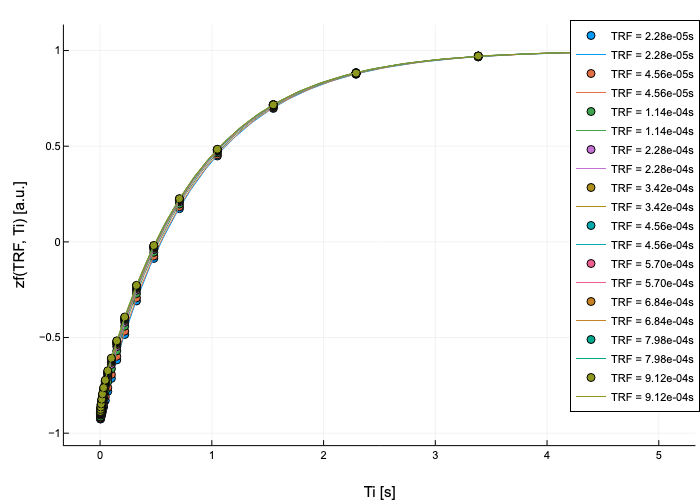

In [43]:
p = plot(xlabel="Ti [s]", ylabel="zf(TRF, Ti) [a.u.]")
for i=1:length(TRF)
    scatter!(p, Ti, M[:,i], label=@sprintf("TRF = %1.2es", TRF[i]), color=i)
    plot!(p, TIplot, gBloch_IR_model(fit.param, G_superLorentzian, TRF[i], TIplot, 1/T2star_BSA), label=@sprintf("TRF = %1.2es", TRF[i]), color=i)
end
gui() #hide

which becomes particularly apparent when zooming into the beginning of the inversion recovery curves. Further, the relative residual norm is much smaller compared to the mono-exponential fit:

In [44]:
norm(fit.resid) / norm(M)

0.004136073097445717

The estimated parameters are

In [45]:
m0 = fit.param[1]

1.0952921963129243

In [46]:
Minv = fit.param[2]

0.929833810917257

In [47]:
m0s = fit.param[3]

0.08544860946745478

In [48]:
R1 = fit.param[4] # 1/s

1.197773204366906

In [49]:
T2s = 1e6fit.param[5] # μs

12.954291748827467

In [50]:
Rx = fit.param[6] # 1/s

71.25327251679374

### Global IR Fit - Graham's Single Frequency Approximation
For comparison, we repeat the same fit with [Graham's single frequency approximation](http://dx.doi.org/10.1002/jmri.1880070520):

In [51]:
function Graham_IR_model(p, TRF, TI, R2f)
    (m0, m0f_inv, m0s, R1, T2s, Rx) = p
    m0f = 1 - m0s
    ω1 = π ./ TRF

    m0vec = [0, 0, m0f, m0s, 1]

    H = [-R1 - m0s * Rx       m0f * Rx R1 * m0f;
               m0s * Rx -R1 - m0f * Rx R1 * m0s;
         0              0              0       ]

    M = zeros(Float64, length(TI), length(TRF))
    for i = 1:length(TRF)
        m = solve(ODEProblem(apply_hamiltonian_graham_superlorentzian!, m0vec, (0.0, TRF[i]), (ω1[i], 1, 0, TRF[i], m0s, R1, R2f, T2s, Rx)))[end]

        for j = 1:length(TI)
            M[j,i] = m0 * (exp(H .* (TI[j] - TRF[i] / 2)) * [m0f_inv * m[3],m[4],1])[1]
        end
    end
    return vec(M)
end

fit = curve_fit((x, p) -> Graham_IR_model(p, TRF, Ti, 1/T2star_BSA), [], vec(M), p0, lower=pmin, upper=pmax)
nothing #hide

Visually, the plot and the data align substantially worse:

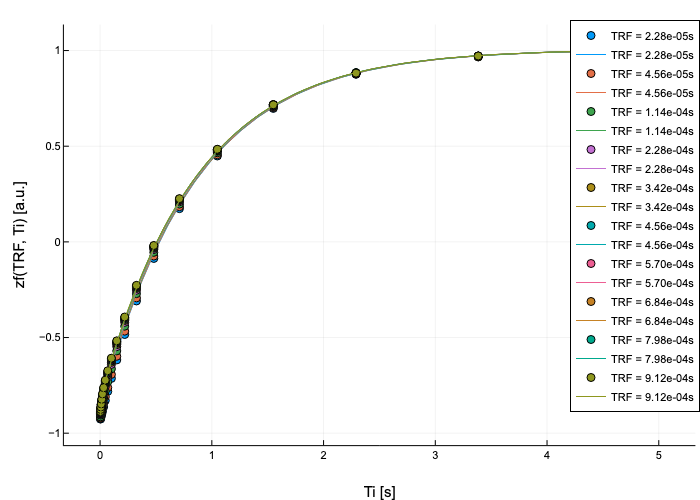

In [52]:
p = plot(xlabel="Ti [s]", ylabel="zf(TRF, Ti) [a.u.]")
for i=1:length(TRF)
    scatter!(p, Ti, M[:,i], label=@sprintf("TRF = %1.2es", TRF[i]), color=i)
    plot!(p, TIplot, Graham_IR_model(fit.param, TRF[i], TIplot, 1/T2star_BSA), label=@sprintf("TRF = %1.2es", TRF[i]), color=i)
end
gui() #hide

which becomes particularly apparent when zooming into the beginning of the inversion recovery curves. Further, the relative residual norm is much larger compared to the generalized Bloch fit:

In [53]:
norm(fit.resid) / norm(M)

0.01832819829710216

The estimated parameters are

In [54]:
m0 = fit.param[1]

1.0833032569637793

In [55]:
Minv = fit.param[2]

0.9405870162861065

In [56]:
m0s = fit.param[3]

0.06992519223646541

In [57]:
R1 = fit.param[4] # 1/s

1.1790784320009184

In [58]:
T2s = 1e6fit.param[5] # μs

2.89521818700757

In [59]:
Rx = fit.param[6] # 1/s

73.86625802764631

### Global IR Fit - Sled's Model
We also performed the fit with [Sled's model](http://dx.doi.org/10.1006/jmre.2000.2059):

In [60]:
function Sled_IR_model(p, G, TRF, TI, R2f)
    (m0, m0f_inv, m0s, R1, T2s, Rx) = p
    m0f = 1 - m0s
    ω1 = π ./ TRF

    m0vec = [0, 0, m0f, m0s, 1]

    H = [-R1 - m0s * Rx       m0f * Rx R1 * m0f;
               m0s * Rx -R1 - m0f * Rx R1 * m0s;
         0              0              0       ]

    M = zeros(Float64, length(TI), length(TRF))
    for i = 1:length(TRF)
        m = solve(ODEProblem(apply_hamiltonian_sled!, m0vec, (0.0, TRF[i]), (ω1[i], 1, 0, m0s, R1, R2f, T2s, Rx, G)))[end]

        for j = 1:length(TI)
            M[j,i] = m0 * (exp(H .* (TI[j] - TRF[i] / 2)) * [m0f_inv * m[3],m[4],1])[1]
        end
    end
    return vec(M)
end

fit = curve_fit((x, p) -> Sled_IR_model(p, G_superLorentzian, TRF, Ti, 1/T2star_BSA), [], vec(M), p0, lower=pmin, upper=pmax)
nothing #hide

Visually, the plot and the data do align well either:

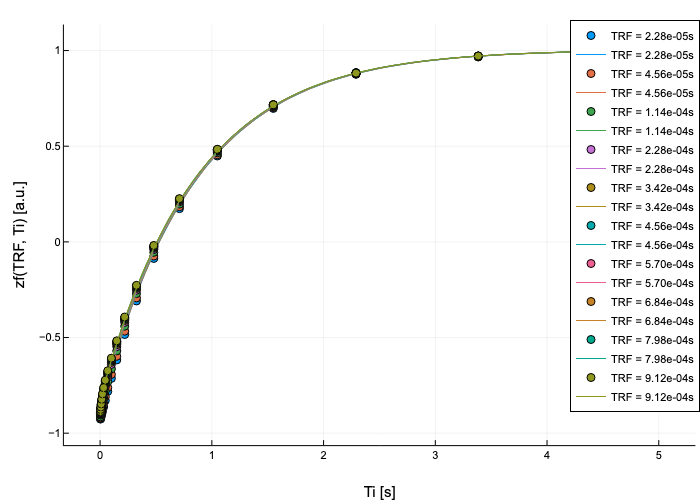

In [61]:
p = plot(xlabel="Ti [s]", ylabel="zf(TRF, Ti) [a.u.]")
for i=1:length(TRF)
    scatter!(p, Ti, M[:,i], label=@sprintf("TRF = %1.2es", TRF[i]), color=i)
    plot!(p, TIplot, Sled_IR_model(fit.param, G_superLorentzian, TRF[i], TIplot, 1/T2star_BSA), label=@sprintf("TRF = %1.2es", TRF[i]), color=i)
end
gui() #hide

which becomes particularly apparent when zooming into the beginning of the inversion recovery curves. Further, the relative residual norm is also large compared to the generalized Bloch fit:

In [62]:
norm(fit.resid) / norm(M)

0.019635632219420694

The estimated parameters are

In [63]:
m0 = fit.param[1]

1.0833070564195646

In [64]:
Minv = fit.param[2]

0.9368003371527377

In [65]:
m0s = fit.param[3]

0.07153507199812162

In [66]:
R1 = fit.param[4] # 1/s

1.1781825569827808

In [67]:
T2s = 1e6fit.param[5] # μs

5.026536562096202

In [68]:
Rx = fit.param[6] # 1/s

60.01953982228783

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*